In [1]:
#various libraries needed to run the functions and code on the final report
# wrangle and evaluate files also imported to pull functions from
import wrangle
import evaluate
import numpy as np
import pandas as pd 

# visualization libraries 
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr, spearmanr

import sklearn.preprocessing

# modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

from sklearn.metrics import explained_variance_score



the wrangle_zillow function performs the necesseary mySQL query to pull the data if it is not already saved in the local directory as CSV files. If you do not have the files saved locally it saves them for you. Outliers are removed both upper and lower to prevent them from skewing the data, boxplots and histograms are printed of all continous variables pulled so you can see their distribution, the few rows that were left that had null values in lot size were dropped altogether, null values for year built was imputed with the median, which is done after the data is split into three groups labeled train, validate, and test.

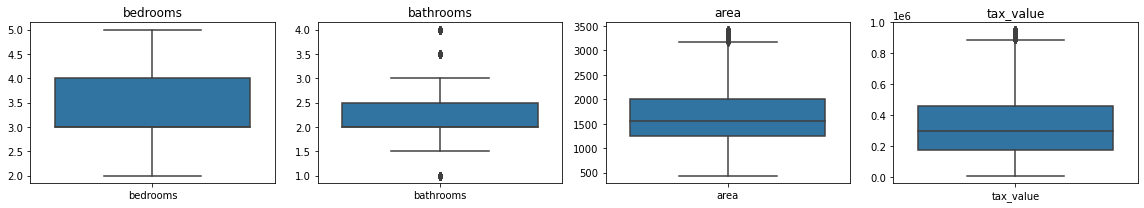

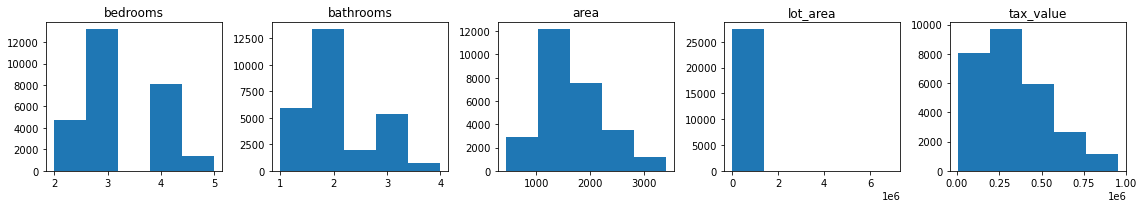

In [2]:
train, validate, test = wrangle.wrangle_zillow()

# Are there any features that have a significant correlation with assessed value?

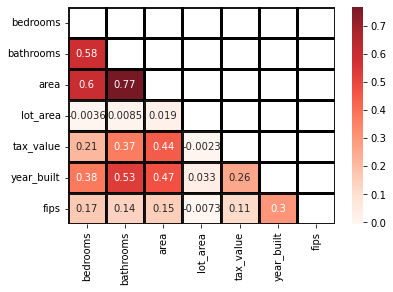

In [3]:
evaluate.create_heat_map(train)

### Looking at the correlation heatmap we can see there are some that have slight positive correlation coefficents. House square feet (area) has the highest with .44

# Do properties with more bedrooms leading to increased assessed value?

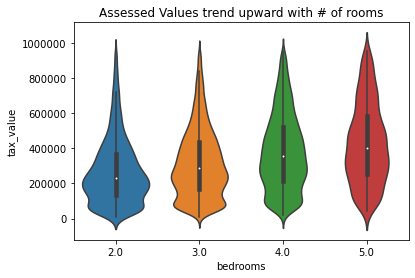

Correlation Coefficient: 0.2116919401026855
P-value: 5.183523254906572e-275


In [4]:
evaluate.create_violin_chart_bedrooms(train)

### Visually we can see the upward trend. By conducting statistical testing and having a near-zero P-value I rejected the null hypothesis that there was no relationship between number of bedrooms and assessed value.

# Does having a higher number of bathrooms lead to increases in assessed value?

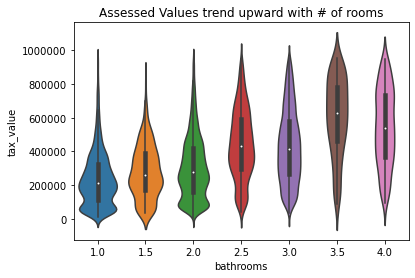

Correlation Coefficient: 0.36935991287106845
P-value: 0.0


In [5]:
evaluate.create_violin_chart_bathrooms(train)

### The plot above shows us there is a noticable upward movement in assessed value as number of bathrooms increases. By testing for linear relationship and resulting in a positive .36 and zero P-value I rejected the null hypothesis of there is no relationship between number of bedrooms and assessed value.

# Does having a house with higher square footage result in increase in assessed value?


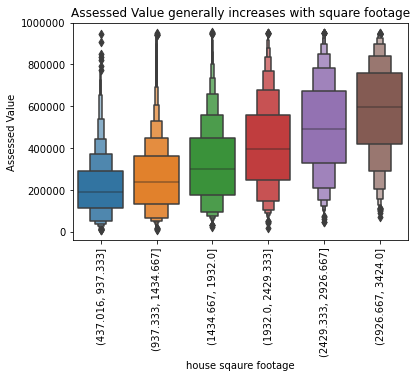

Correlation Coefficient: 0.44486879390478085
P-value: 0.0


In [6]:
#create boxen plot of assesed value and area

evaluate.create_boxen_plot_area(train)

### The boxen plot above shows us there's an easily identifiable visual upward trend.  I conducted a correlation coefficient (pearson's r, same for previous tests since all is somewhat normally distributed) and with a .44 correlation coefficient and a zero for p-value I rejected the null hypothesis that there is no relationship between square footage of a house and assessed value.

# Does looking at square footage by excluding bedrooms and bathrooms have a relationship with assessed value?

In [7]:
# I had to create a new feature to run this test. I found the avg sq ft of master bedrooms, guest bedrooms, and of bathrooms and
#created a formula to get the total area of bedrooms and bathrooms and subracted that from the total area of the house. 
# The result is the non_bed_bath_area column.

evaluate.feature_engineer(train,validate,test)

train.head()

,bedrooms,bathrooms,area,lot_area,tax_value,year_built,fips,lot_living_ratio,non_bed_bath_area
0,4.0,3.0,3105.0,7140.0,514262.0,1986.0,6059.0,0.434874,2979.0
1,3.0,1.0,1010.0,6245.0,144398.0,1950.0,6037.0,0.161729,728.0
2,3.0,1.0,1154.0,7035.0,45731.0,1947.0,6037.0,0.164037,872.0
3,3.0,2.0,1546.0,6630.0,154605.0,1973.0,6111.0,0.233183,1414.0
4,3.0,1.0,940.0,6080.0,436455.0,1957.0,6059.0,0.154605,658.0


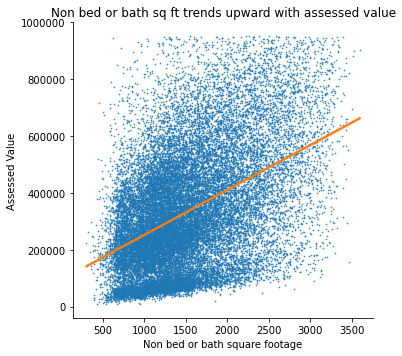

Correlation Coefficient: 0.4538605459106819
P-value: 0.0


In [8]:
evaluate.regplot_engineered_feat(train)

### Using the engineered feature mentioned above I put it in a scatter plot with a regression line overlay. The resulting visual shows the appearance of a definate upward trend.  Statistical testing confirmed what we see with .45 correlation coefficient and zero for a p-value. This is why I rejected my null hypothesis that there is no relationship bewteen non bed/bath square feet and assessed value.

### all null and alternate hypothesis can be found fully written in README.md file

# Exploration results

all testing resulted in showing various slight positive linear correlation relationships with low p-values that commensurate with the fact these findings are statistically significant. Because of this I chose to include all of the aforementioned features when I moved on to creating my models. The feature I chose to not use in modeling was fips due to having almost zero correlation in my heatmap.

In [9]:
# this function that is pulled from the evaluate.py file splits off the target variable in all 3 data sets to create the "X" values, 
#and the y values are just the single target variable

X_train, y_train, X_validate, y_validate, X_test, y_test=evaluate.X_and_y_split(train,validate,test)



# looking at the distrubion of our target variable assessed value below we can see it is normal. This guides also on what statistical tests are appropriate.

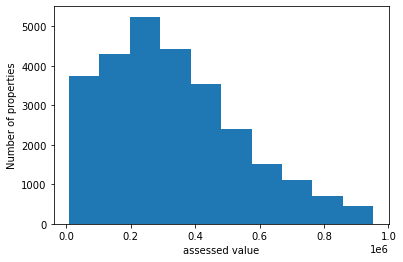

In [10]:
#pulls the assessed value from the train data set and graphs the distrubution 

evaluate.target_var_dist(y_train)

In [11]:
# this is where a min/max scaler is applied to all of the "X" dataframes and stored into new variables

X_train_scaled, X_validate_scaled, X_test_scaled=evaluate.scale_data(X_train,X_validate,X_test)

In [12]:
# both the mean and median assessed values are used to evaluate which is best for our baseline
evaluate.calc_baseline(y_train,y_validate)

RMSE using Mean
Train/In-Sample:  206984.12 
Validate/Out-of-Sample:  210683.12
RMSE using Median
Train/In-Sample:  209863.51 
Validate/Out-of-Sample:  214214.18


## I computed both the mean and median assessed values and used these figures to evaluate each independently via RMSE method. I ran them both on in and out of sample data. the mean has a slightly better performance so that is what I chose as a baseline to compare my models against.

# OLS MODEL

In [13]:
import warnings
warnings.filterwarnings("ignore")

# create the model object
lm = LinearRegression(normalize=True)

# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train_scaled, y_train.tax_value)

# predict train
y_train['value_pred_lm'] = lm.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.value_pred_lm)**(1/2)

# predict validate
y_validate['value_pred_lm'] = lm.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.value_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for OLS using LinearRegression
Training/In-Sample:  183755.64497188947 
Validation/Out-of-Sample:  187178.42076879318


In [14]:
# create the model object
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train_scaled, y_train.tax_value)

# predict train
y_train['value_pred_lars'] = lars.predict(X_train_scaled)

# evaluate: rmse
rmse_train_lars = mean_squared_error(y_train.tax_value, y_train.value_pred_lars)**(1/2)

# predict validate
y_validate['value_pred_lars'] = lars.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate_lars = mean_squared_error(y_validate.tax_value, y_validate.value_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train_lars, 
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for Lasso + Lars
Training/In-Sample:  183755.76572577737 
Validation/Out-of-Sample:  187178.42076879318


In [15]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train_scaled)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate_scaled)


In [16]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.tax_value)

# predict train
y_train['value_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.value_pred_lm2)**(1/2)

# predict validate
y_validate['value_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.value_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for Polynomial Model, degrees=2
Training/In-Sample:  181478.14191170185 
Validation/Out-of-Sample:  184858.80914542434


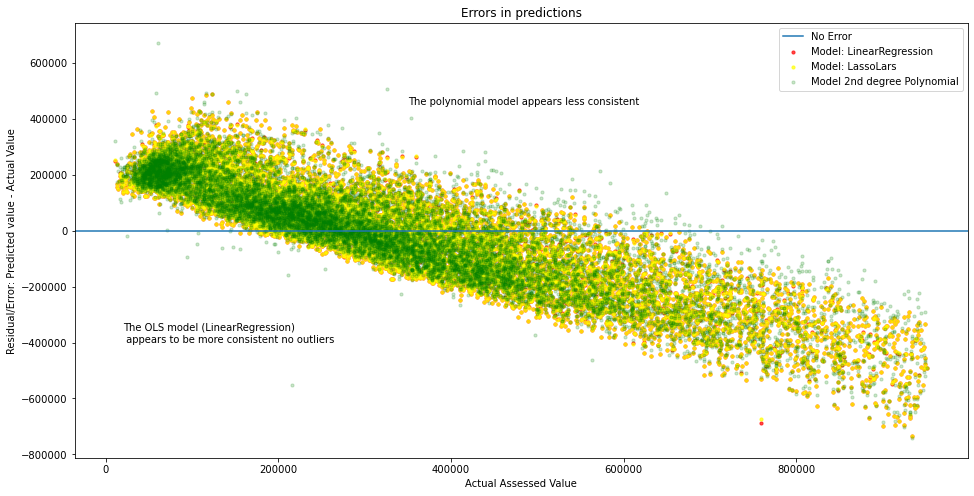

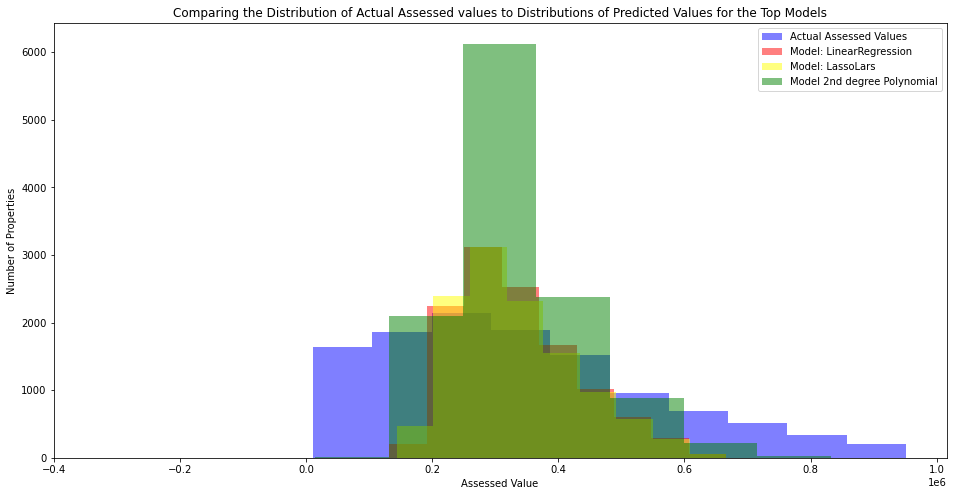

Explained Variance linear regression =  0.212
Explained Variance LassoLars =  0.212
Explained Variance Polynomial regression =  0.231


In [17]:
# function takes the errors of all three different models and graphs them on top of each other

evaluate.model_eval_compare(y_train,y_validate)

# I used RMSE, visual representations, and R^2 measurements to look at which model I felt would be best. I ended up using both the visual charts and  the RMSE figures to make my decision and selected the OLS model. this model was tied with Lasso/Lars, but the visual shows what I believe a slight advantage to the OLS.  This is what I chose to use on my test data set.

In [18]:
#Model selected: lm (using LinearRegression)

y_test = pd.DataFrame(y_test)

# predict on test
y_test['value_pred_lm'] = lm.predict(X_test_scaled)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.tax_value, y_test.value_pred_lm)**(1/2)

print("RMSE for OLS Model using LinearRegression\nOut-of-Sample Performance: ", rmse_test)


evs_lm = explained_variance_score(y_test.tax_value, y_test.value_pred_lm)
print('Out of sample Explained Variance linear regression = ', round(evs_lm,3))

RMSE for OLS Model using LinearRegression
Out-of-Sample Performance:  182985.6961055991
Out of sample Explained Variance linear regression =  0.218


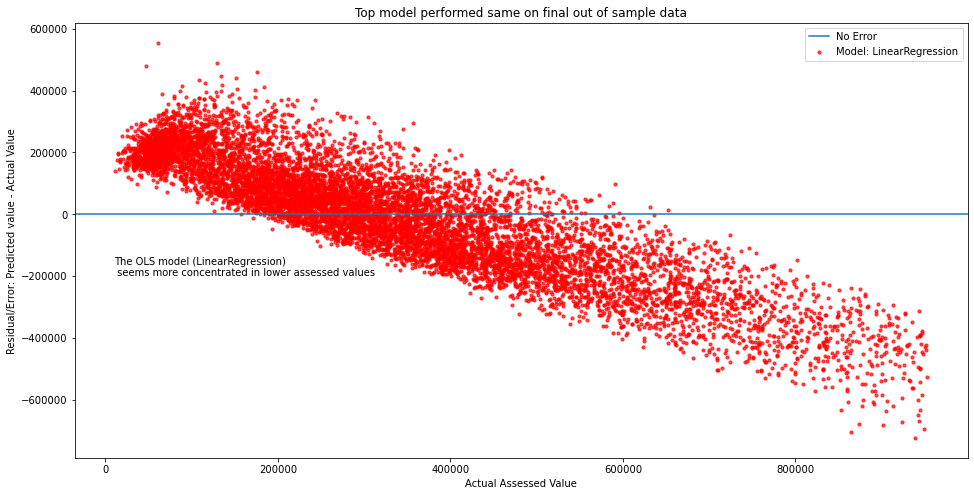

In [19]:
#shows the performance of final model on test data

evaluate.show_best_model_on_test(y_test)

## my best model actually saw a slight improvement on the test data set and beat my baseline.

# conclusion

I looked at number of bedrooms, bathrooms, square footage, and square footage not included in bed or bath as features and confirmed they all have a slight statistically significant positive linear correlation. My best model performed consistently across data sets and even slightly improved in the final test data set. I expect this model will perform similarly on future data.

If you notice the graphs of errors in predicions there is unmistakable downward trend compared to actual values. This suggests there are other features not yet captured in my models driving that trend. My highest correlated feature to assessed value was the one I engineered.  For a business perspective I recommend incorporating my desined features into zillow's current model to increase its accuracy. 

If time allowed I would like to re evaluate the zillow database for possible appropriate features to improve my model's accuracy that are not derived from square footage of the house, do some feature engineering, and rerun the predictions. While my top model surely beats the baseline I feel it is far from a huge success. much improvement is possible.